In [2]:
import pyodbc
import pandas as pd
import swifter
import seaborn as sns
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold,  GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.impute import SimpleImputer
import numpy as np
import evalml
gc.collect()

0

In [2]:
pd.__version__

'1.4.2'

# Load Data

In [2]:
with pyodbc.connect('DRIVER={SQL SERVER};SERVER=SAS-CI-DB1-P') as conn:
    strq = 'SELECT DISTINCT phone\
                    , CommFlag\
                    , OrderFlag\
                    , Order_Ago\
                    , min_diff\
                    , max_diff\
                    , avg_diff\
                    , avg_check\
                    , avg_mass_check\
                    , Mean_Item_Cost\
                    , sum_amount_18\
                    , cnt_amount_18\
                    , Mass_amount_18\
                    , Parfume_AMOUNT_18\
                    , Lux_Parfume_AMOUNT_18\
                    , sum_amount_3\
                    , sum_amount_6\
                    , sum_amount_9\
                    , sum_amount_12\
                    , sum_amount_15\
                    , cnt_amount_3\
                    , cnt_amount_6\
                    , cnt_amount_9\
                    , cnt_amount_12\
                    , cnt_amount_15\
                    , Mass_amount_3\
                    , Mass_amount_6\
                    , Mass_amount_9\
                    , Mass_amount_12\
                    , Mass_amount_15\
                    , Parfume_Amount_3\
                    , Parfume_Amount_6\
                    , Parfume_Amount_9\
                    , Parfume_Amount_12\
                    , Parfume_Amount_15\
                    , Lux_Parfume_Amount_3\
                    , Lux_Parfume_Amount_6\
                    , Lux_Parfume_Amount_9\
                    , Lux_Parfume_Amount_12\
                    , Lux_Parfume_Amount_15\
                    , age\
                    , LIFECYCLE_TYPE\
                    , sex \
                    FROM ##DataSet\
                    WHERE cnt_amount_18 > 0'
    df = pd.read_sql(strq, conn)

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


In [3]:
df.dtypes

phone                     object
CommFlag                   int64
OrderFlag                  int64
Order_Ago                  int64
min_diff                 float64
max_diff                 float64
avg_diff                 float64
avg_check                float64
avg_mass_check           float64
Mean_Item_Cost           float64
sum_amount_18            float64
cnt_amount_18              int64
Mass_amount_18           float64
Parfume_AMOUNT_18        float64
Lux_Parfume_AMOUNT_18    float64
sum_amount_3             float64
sum_amount_6             float64
sum_amount_9             float64
sum_amount_12            float64
sum_amount_15            float64
cnt_amount_3               int64
cnt_amount_6               int64
cnt_amount_9               int64
cnt_amount_12              int64
cnt_amount_15              int64
Mass_amount_3            float64
Mass_amount_6            float64
Mass_amount_9            float64
Mass_amount_12           float64
Mass_amount_15           float64
Parfume_Am

In [4]:
df.head()

,phone,CommFlag,OrderFlag,Order_Ago,min_diff,max_diff,avg_diff,avg_check,avg_mass_check,Mean_Item_Cost,...,Parfume_Amount_12,Parfume_Amount_15,Lux_Parfume_Amount_3,Lux_Parfume_Amount_6,Lux_Parfume_Amount_9,Lux_Parfume_Amount_12,Lux_Parfume_Amount_15,age,LIFECYCLE_TYPE,sex
0,70000136255,1,0,5,3.0,9.0,6.0,2637.8888,2245.00,1582.733333,...,10307.0,10307.0,NaN,NaN,NaN,NaN,NaN,24.0,0,0.0
1,70001625391,1,0,6,141.0,369.0,255.0,7568.7500,7566.25,2522.916667,...,15083.0,15083.0,NaN,NaN,NaN,NaN,NaN,38.0,1,1.0
2,70021067460,1,0,15,240.0,240.0,240.0,229.0000,229.00,229.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0,1,0.0
3,70032000019,1,0,10,NaN,NaN,NaN,2598.5000,2598.50,1299.250000,...,2149.5,2149.5,NaN,NaN,NaN,NaN,NaN,57.0,1,0.0
4,70131878044,1,0,14,1.0,35.0,17.0,955.7111,933.65,614.385714,...,NaN,4206.0,NaN,NaN,NaN,NaN,NaN,21.0,1,0.0


In [9]:
# med = df.age.median()
# df.age = df.age.swifter.apply(lambda x: x if (x > 16) and (x < 80) else med)
# df.age = df.age.fillna(med)
# df.sex = df.sex.fillna(round(df.sex.median()))
# df.Order_Ago = df.Order_Ago.fillna(36)


Dask Apply: 100%|██████████| 12/12 [00:03<00:00,  3.39it/s]


In [5]:
df.head()

,phone,CommFlag,OrderFlag,Order_Ago,min_diff,max_diff,avg_diff,avg_check,avg_mass_check,Mean_Item_Cost,...,Parfume_Amount_12,Parfume_Amount_15,Lux_Parfume_Amount_3,Lux_Parfume_Amount_6,Lux_Parfume_Amount_9,Lux_Parfume_Amount_12,Lux_Parfume_Amount_15,age,LIFECYCLE_TYPE,sex
0,70000136255,1,0,5,3.0,9.0,6.0,2637.8888,2245.00,1582.733333,...,10307.0,10307.0,NaN,NaN,NaN,NaN,NaN,24.0,0,0.0
1,70001625391,1,0,6,141.0,369.0,255.0,7568.7500,7566.25,2522.916667,...,15083.0,15083.0,NaN,NaN,NaN,NaN,NaN,38.0,1,1.0
2,70021067460,1,0,15,240.0,240.0,240.0,229.0000,229.00,229.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0,1,0.0
3,70032000019,1,0,10,NaN,NaN,NaN,2598.5000,2598.50,1299.250000,...,2149.5,2149.5,NaN,NaN,NaN,NaN,NaN,57.0,1,0.0
4,70131878044,1,0,14,1.0,35.0,17.0,955.7111,933.65,614.385714,...,NaN,4206.0,NaN,NaN,NaN,NaN,NaN,21.0,1,0.0


In [6]:
df.describe()

,CommFlag,OrderFlag,Order_Ago,min_diff,max_diff,avg_diff,avg_check,avg_mass_check,Mean_Item_Cost,sum_amount_18,...,Parfume_Amount_12,Parfume_Amount_15,Lux_Parfume_Amount_3,Lux_Parfume_Amount_6,Lux_Parfume_Amount_9,Lux_Parfume_Amount_12,Lux_Parfume_Amount_15,age,LIFECYCLE_TYPE,sex
count,848030.000000,848030.00000,848030.000000,731399.000000,731399.000000,731399.000000,848030.000000,820101.000000,848030.000000,8.480300e+05,...,5.100100e+05,5.491040e+05,1.912700e+04,4.607200e+04,6.983300e+04,9.572400e+04,1.124020e+05,801401.000000,848030.000000,821137.000000
mean,0.756904,0.06261,5.536977,138.477943,301.274760,205.992616,2818.653903,2510.238606,1768.026428,1.126126e+04,...,7.629662e+03,8.685284e+03,5.982303e+03,5.657979e+03,5.634988e+03,5.558762e+03,5.708032e+03,43.307657,0.915794,0.111386
std,0.428953,0.24226,3.870152,198.884617,179.938566,178.456342,2407.374612,2168.477299,1871.147462,6.247594e+04,...,3.784145e+04,4.782720e+04,1.511939e+04,1.449019e+04,1.490326e+04,1.542584e+04,1.677240e+04,11.862788,0.277696,0.314609
min,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,-1424.875000,-1424.875000,-0.500000,-2.849750e+03,...,-1.677625e+04,-1.031325e+04,-9.900000e+03,-1.192500e+04,-1.192500e+04,-2.250000e+04,-1.192500e+04,13.000000,0.000000,0.000000
25%,1.000000,0.00000,2.000000,9.000000,173.000000,83.000000,1298.646250,1033.775000,599.850000,2.969000e+03,...,2.949500e+03,3.114300e+03,1.999500e+03,1.994300e+03,1.924500e+03,1.837500e+03,1.836750e+03,35.000000,1.000000,0.000000
50%,1.000000,0.00000,5.000000,44.000000,265.000000,145.000000,2302.350000,2024.125000,1229.400000,6.372275e+03,...,4.875000e+03,5.385000e+03,3.099500e+03,3.099500e+03,3.008600e+03,2.949500e+03,2.949500e+03,42.000000,1.000000,0.000000
75%,1.000000,0.00000,8.000000,182.000000,386.000000,268.000000,3674.854950,3389.070000,2275.072917,1.278755e+04,...,8.594400e+03,9.735000e+03,6.038950e+03,5.774300e+03,5.774300e+03,5.739300e+03,5.811750e+03,51.000000,1.000000,0.000000
max,1.000000,1.00000,18.000000,1168.000000,1168.000000,1168.000000,505250.000000,505250.000000,54465.100000,1.200998e+07,...,4.863092e+06,5.792420e+06,1.550702e+06,1.984067e+06,1.984067e+06,1.984067e+06,1.984067e+06,93.000000,1.000000,1.000000


In [7]:
df.to_csv('DataSetUpLif.csv', index = False, sep = ';')

In [8]:
#print('Median age ', med)

NameError: name 'med' is not defined

In [9]:
del df

# EDA

In [3]:
df = pd.read_csv('DataSetUpLif.csv', sep = ';', dtype={'phone':'str'})

In [4]:
print(df.shape)
df.head()

(7450851, 43)


,phone,CommFlag,OrderFlag,Order_Ago,min_diff,max_diff,avg_diff,avg_check,avg_mass_check,Mean_Item_Cost,...,Parfume_Amount_12,Parfume_Amount_15,Lux_Parfume_Amount_3,Lux_Parfume_Amount_6,Lux_Parfume_Amount_9,Lux_Parfume_Amount_12,Lux_Parfume_Amount_15,age,LIFECYCLE_TYPE,sex
0,70000068068,0,0,10,NaN,NaN,NaN,1844.0000,1844.000,1844.000000,...,1844.00,1844.00,NaN,NaN,NaN,NaN,NaN,47.0,1,0.0
1,70000103922,0,0,1,1.0,98.0,27.0,3286.7733,3169.715,3389.485000,...,54882.42,71873.42,NaN,NaN,1754.42,1754.42,1754.42,33.0,1,0.0
2,70000142841,0,0,1,NaN,NaN,NaN,648.0000,NaN,324.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
3,70001625391,0,0,12,141.0,141.0,141.0,7568.7500,7566.250,2522.916667,...,NaN,4973.50,NaN,NaN,NaN,NaN,NaN,38.0,1,1.0
4,70001659862,0,0,9,192.0,192.0,192.0,1099.0000,1099.000,732.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,1,0.0


In [5]:
print(df.dtypes)
print(df.shape)

phone                     object
CommFlag                   int64
OrderFlag                  int64
Order_Ago                  int64
min_diff                 float64
max_diff                 float64
avg_diff                 float64
avg_check                float64
avg_mass_check           float64
Mean_Item_Cost           float64
sum_amount_18            float64
cnt_amount_18              int64
Mass_amount_18           float64
Parfume_AMOUNT_18        float64
Lux_Parfume_AMOUNT_18    float64
sum_amount_3             float64
sum_amount_6             float64
sum_amount_9             float64
sum_amount_12            float64
sum_amount_15            float64
cnt_amount_3               int64
cnt_amount_6               int64
cnt_amount_9               int64
cnt_amount_12              int64
cnt_amount_15              int64
Mass_amount_3            float64
Mass_amount_6            float64
Mass_amount_9            float64
Mass_amount_12           float64
Mass_amount_15           float64
Parfume_Am

In [5]:
df = df.set_index('phone')
df.head()

,CommFlag,OrderFlag,Order_Ago,min_diff,max_diff,avg_diff,avg_check,avg_mass_check,Mean_Item_Cost,sum_amount_18,...,Parfume_Amount_12,Parfume_Amount_15,Lux_Parfume_Amount_3,Lux_Parfume_Amount_6,Lux_Parfume_Amount_9,Lux_Parfume_Amount_12,Lux_Parfume_Amount_15,age,LIFECYCLE_TYPE,sex
phone,,,,,,,,,,,,,,,,,,,,,
70000068068,0,0,10,NaN,NaN,NaN,1844.0000,1844.000,1844.000000,1844.00,...,1844.00,1844.00,NaN,NaN,NaN,NaN,NaN,47.0,1,0.0
70000103922,0,0,1,1.0,98.0,27.0,3286.7733,3169.715,3389.485000,108463.52,...,54882.42,71873.42,NaN,NaN,1754.42,1754.42,1754.42,33.0,1,0.0
70000142841,0,0,1,NaN,NaN,NaN,648.0000,NaN,324.000000,648.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
70001625391,0,0,12,141.0,141.0,141.0,7568.7500,7566.250,2522.916667,15137.50,...,NaN,4973.50,NaN,NaN,NaN,NaN,NaN,38.0,1,1.0
70001659862,0,0,9,192.0,192.0,192.0,1099.0000,1099.000,732.666667,2198.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,1,0.0


In [6]:
any(df.isna())

True

In [7]:
df.iloc[:, 3:-3] = df.iloc[:, 3:-3].fillna(0)
df.sex = df.sex.fillna(0)
df.age = df.age.fillna(35)

In [8]:
df.iloc[:, 3:-3].head()

,min_diff,max_diff,avg_diff,avg_check,avg_mass_check,Mean_Item_Cost,sum_amount_18,cnt_amount_18,Mass_amount_18,Parfume_AMOUNT_18,...,Parfume_Amount_3,Parfume_Amount_6,Parfume_Amount_9,Parfume_Amount_12,Parfume_Amount_15,Lux_Parfume_Amount_3,Lux_Parfume_Amount_6,Lux_Parfume_Amount_9,Lux_Parfume_Amount_12,Lux_Parfume_Amount_15
phone,,,,,,,,,,,,,,,,,,,,,
70000068068,0.0,0.0,0.0,1844.0000,1844.000,1844.000000,1844.00,1,1844.0,1844.00,...,0.0,0.00,0.00,1844.00,1844.00,0.0,0.0,0.00,0.00,0.00
70000103922,1.0,98.0,27.0,3286.7733,3169.715,3389.485000,108463.52,33,95165.7,71873.42,...,13831.7,30203.47,49168.38,54882.42,71873.42,0.0,0.0,1754.42,1754.42,1754.42
70000142841,0.0,0.0,0.0,648.0000,0.000,324.000000,648.00,1,0.0,0.00,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00
70001625391,141.0,141.0,141.0,7568.7500,7566.250,2522.916667,15137.50,2,15132.5,15083.00,...,0.0,0.00,0.00,0.00,4973.50,0.0,0.0,0.00,0.00,0.00
70001659862,192.0,192.0,192.0,1099.0000,1099.000,732.666667,2198.00,2,2198.0,0.00,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00


In [9]:
df.head()

,CommFlag,OrderFlag,Order_Ago,min_diff,max_diff,avg_diff,avg_check,avg_mass_check,Mean_Item_Cost,sum_amount_18,...,Parfume_Amount_12,Parfume_Amount_15,Lux_Parfume_Amount_3,Lux_Parfume_Amount_6,Lux_Parfume_Amount_9,Lux_Parfume_Amount_12,Lux_Parfume_Amount_15,age,LIFECYCLE_TYPE,sex
phone,,,,,,,,,,,,,,,,,,,,,
70000068068,0,0,10,0.0,0.0,0.0,1844.0000,1844.000,1844.000000,1844.00,...,1844.00,1844.00,0.0,0.0,0.00,0.00,0.00,47.0,1,0.0
70000103922,0,0,1,1.0,98.0,27.0,3286.7733,3169.715,3389.485000,108463.52,...,54882.42,71873.42,0.0,0.0,1754.42,1754.42,1754.42,33.0,1,0.0
70000142841,0,0,1,0.0,0.0,0.0,648.0000,0.000,324.000000,648.00,...,0.00,0.00,0.0,0.0,0.00,0.00,0.00,35.0,1,0.0
70001625391,0,0,12,141.0,141.0,141.0,7568.7500,7566.250,2522.916667,15137.50,...,0.00,4973.50,0.0,0.0,0.00,0.00,0.00,38.0,1,1.0
70001659862,0,0,9,192.0,192.0,192.0,1099.0000,1099.000,732.666667,2198.00,...,0.00,0.00,0.0,0.0,0.00,0.00,0.00,21.0,1,0.0


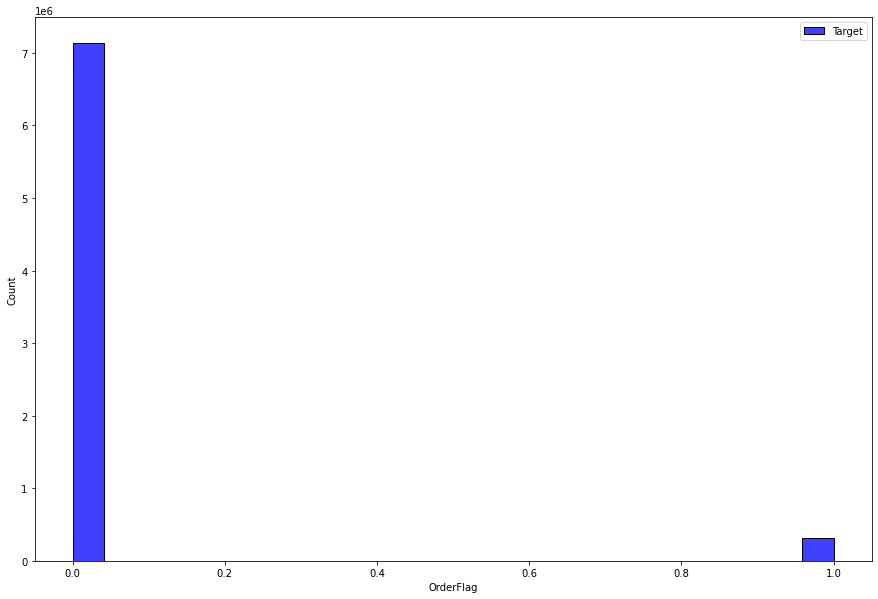

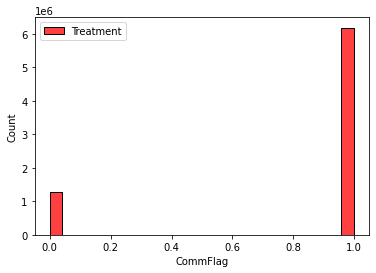

In [10]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (15, 10))
sns.histplot(df.OrderFlag, label = 'Target', color = 'blue')
plt.legend()
plt.show()

sns.histplot(df.CommFlag, label = 'Treatment', color = 'red')
plt.legend()
plt.show()

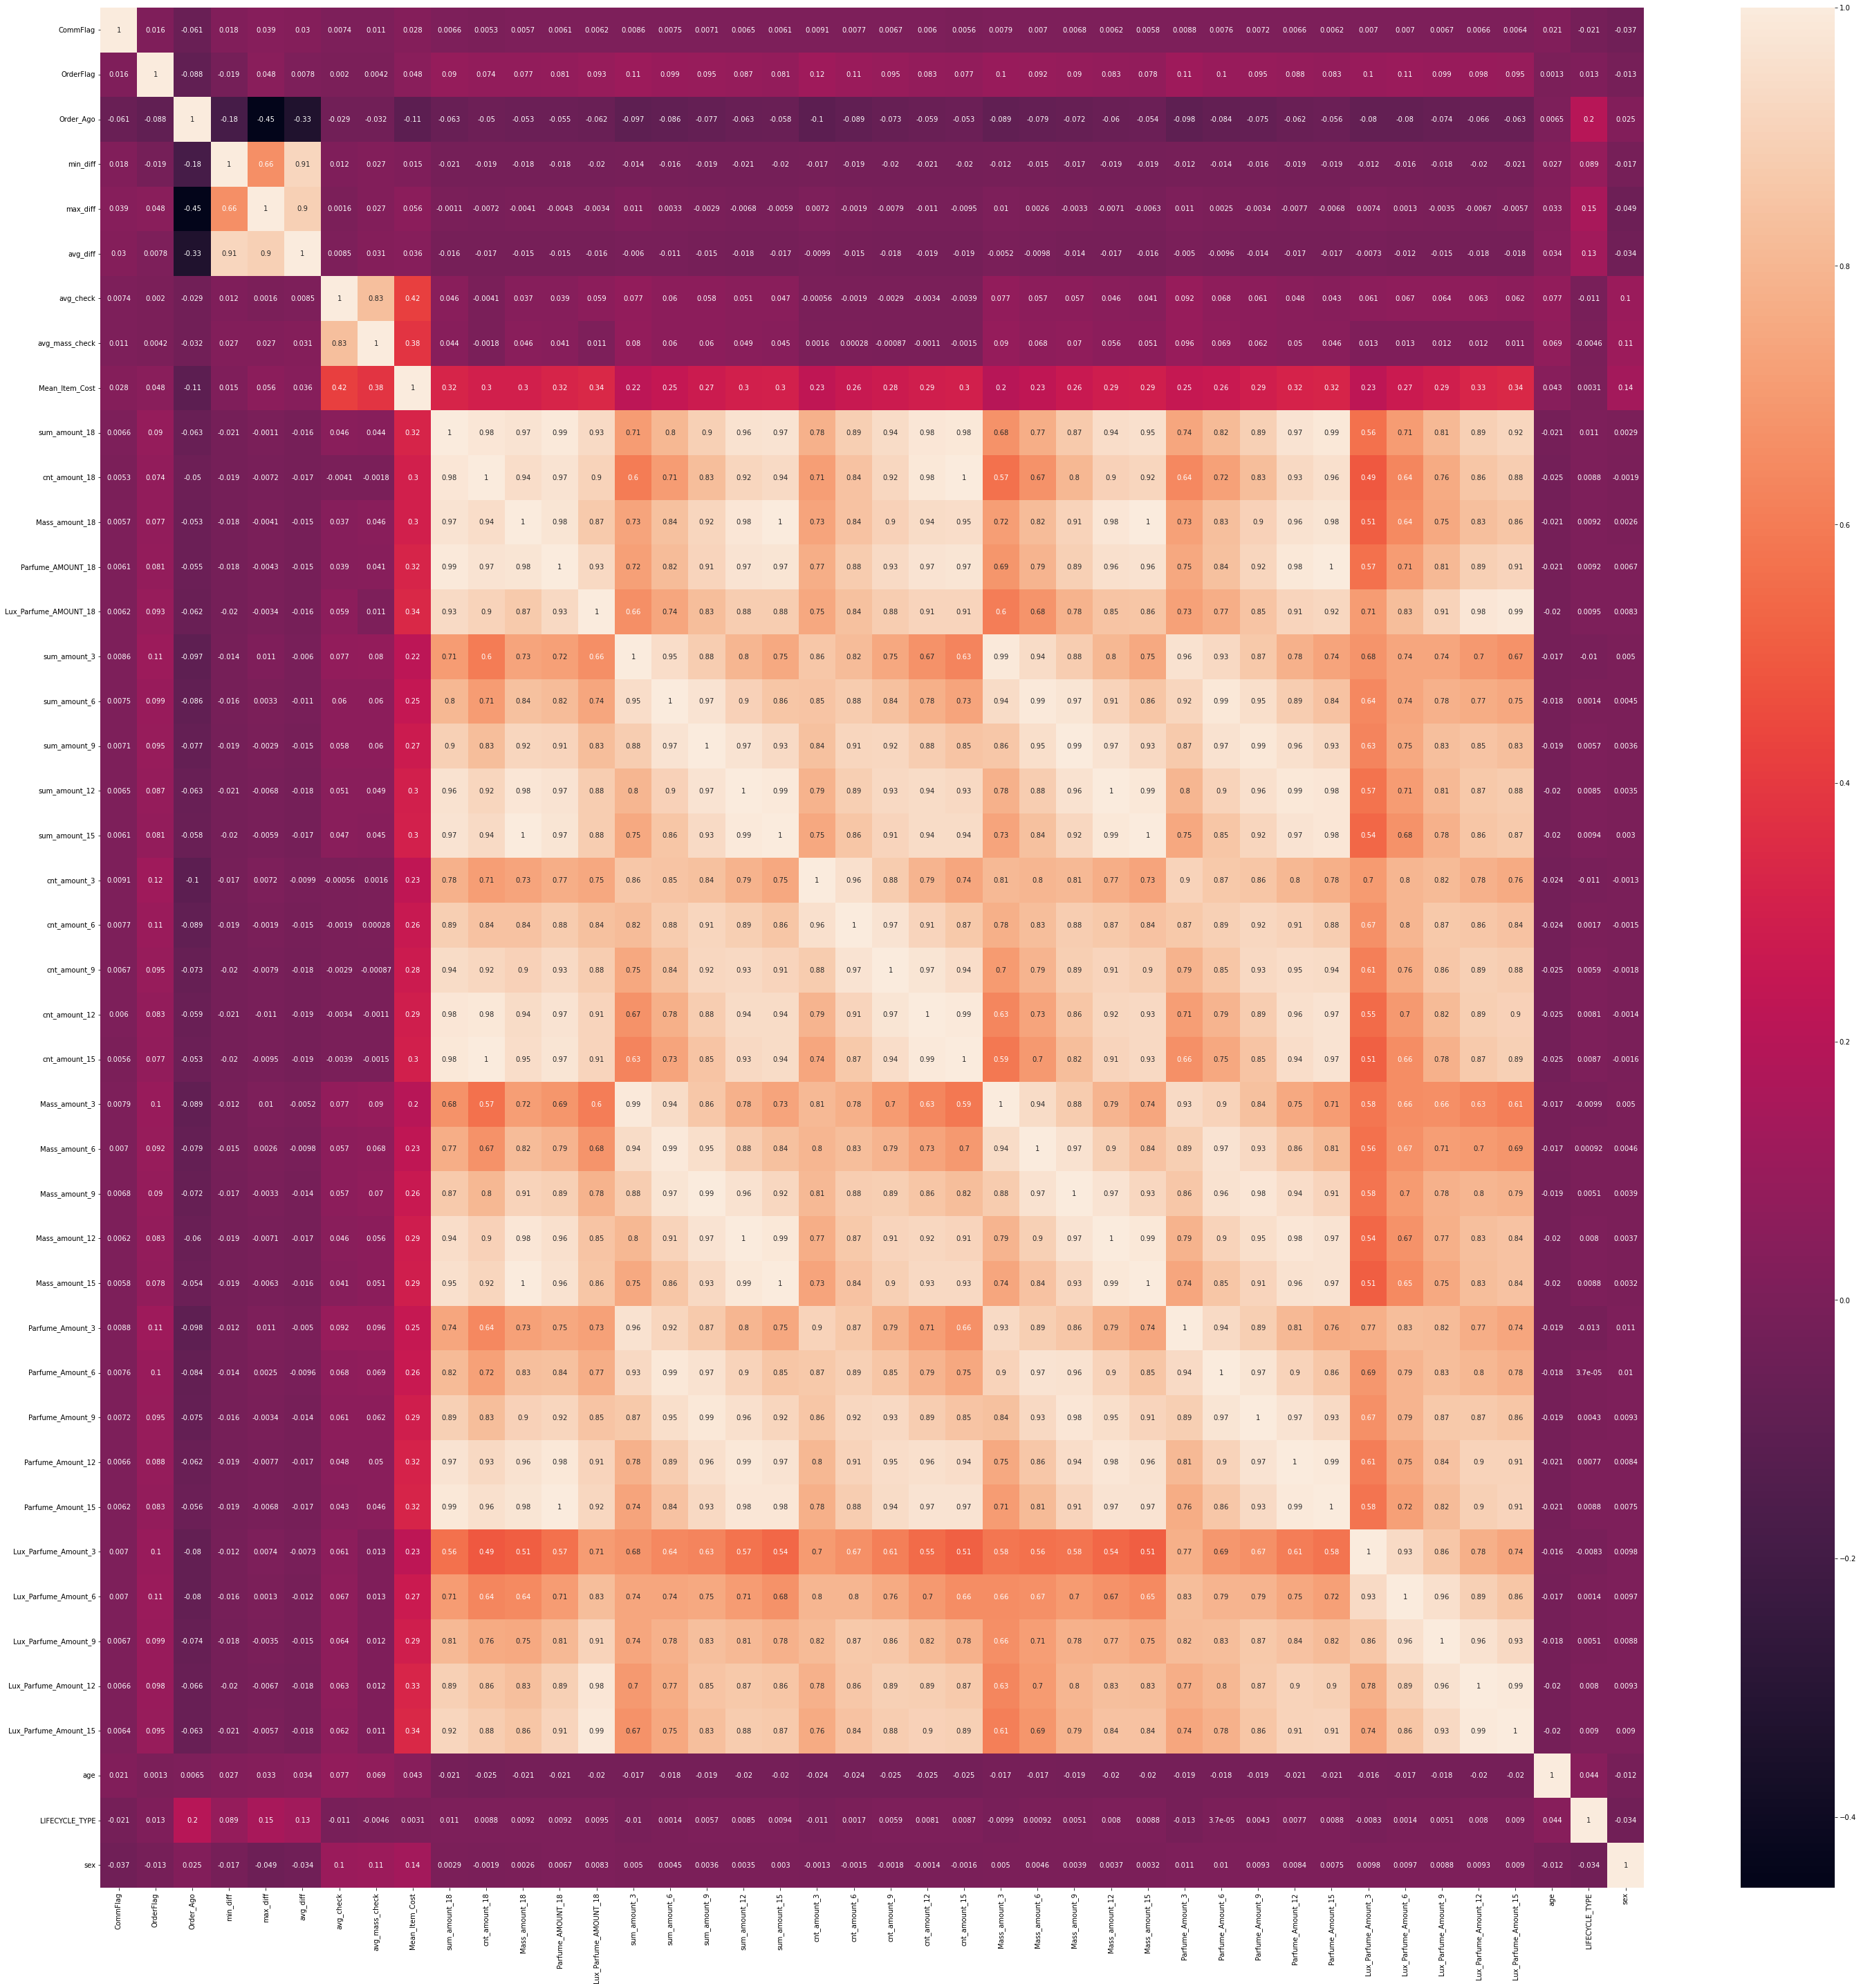

In [11]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (50, 50))
corr_matrix = df.corr()

#Using heatmap to visualize the correlation matrix
sns.heatmap(corr_matrix, annot=True, ax = ax)
del corr_matrix

In [11]:
df.iloc[:, 2:].head()

,Order_Ago,min_diff,max_diff,avg_diff,avg_check,avg_mass_check,Mean_Item_Cost,sum_amount_18,cnt_amount_18,Mass_amount_18,...,Parfume_Amount_12,Parfume_Amount_15,Lux_Parfume_Amount_3,Lux_Parfume_Amount_6,Lux_Parfume_Amount_9,Lux_Parfume_Amount_12,Lux_Parfume_Amount_15,age,LIFECYCLE_TYPE,sex
phone,,,,,,,,,,,,,,,,,,,,,
70000068068,10,0.0,0.0,0.0,1844.0000,1844.000,1844.000000,1844.00,1,1844.0,...,1844.00,1844.00,0.0,0.0,0.00,0.00,0.00,47.0,1,0.0
70000103922,1,1.0,98.0,27.0,3286.7733,3169.715,3389.485000,108463.52,33,95165.7,...,54882.42,71873.42,0.0,0.0,1754.42,1754.42,1754.42,33.0,1,0.0
70000142841,1,0.0,0.0,0.0,648.0000,0.000,324.000000,648.00,1,0.0,...,0.00,0.00,0.0,0.0,0.00,0.00,0.00,35.0,1,0.0
70001625391,12,141.0,141.0,141.0,7568.7500,7566.250,2522.916667,15137.50,2,15132.5,...,0.00,4973.50,0.0,0.0,0.00,0.00,0.00,38.0,1,1.0
70001659862,9,192.0,192.0,192.0,1099.0000,1099.000,732.666667,2198.00,2,2198.0,...,0.00,0.00,0.0,0.0,0.00,0.00,0.00,21.0,1,0.0


In [12]:
y = df.iloc[:, 0:2]
p = round(y[y.CommFlag == 1].shape[0] / y.shape[0], 1) #0.5
Z = y.OrderFlag * (y.CommFlag - p) / (p * (1-p)) 
del y

gc.collect()
gc.enable()

features = df.iloc[:, 2:].columns.tolist()
X = df.iloc[:, 2:].values
del df
gc.collect()



    

0

In [13]:
gc.collect()

0

In [14]:
p

0.8

In [15]:
#X.head()

In [16]:
Z.describe()

count    7.450851e+06
mean     1.581480e-02
std      4.528949e-01
min     -5.000000e+00
25%     -0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.250000e+00
dtype: float64

In [17]:
# imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
# scaler = StandardScaler()
# X = scaler.fit_transform(imp_mean.fit_transform(X))
# pd.isna(X).any()


In [18]:
# gc.collect()
# del X_test
# del X_train
# del y_test
# del y_train
# del automl

In [19]:
gc.collect()

0

In [20]:
from evalml import AutoMLSearch

In [21]:
#X_train,X_test,y_train,y_test=evalml.preprocessing.split_data(X, y,problem_type='binary')
X_train,X_test,y_train,y_test=evalml.preprocessing.split_data(X, Z,problem_type='regression')

In [22]:
del X
del Z
gc.collect()
gc.enable()

In [23]:
# automl=AutoMLSearch(X_train = X_train
#                     , y_train = y_train
#                     , n_jobs = -1
#                     , problem_type='binary'
#                     , verbose = True
#                     # , max_batches = 1
#                     # , optimize_thresholds=True
#                     # , ensembling=True
#                     # , max_iterations = 10
#                     #, allowed_model_families = evalml.pipelines.components.utils.allowed_model_families('binary')
#                     )

# automl=AutoMLSearch(X_train = X_train
#                     , y_train = y_train
#                     , n_jobs = -1
#                     , problem_type='regression'
#                     , verbose = True
#                      , objective = 'mse'
#                     # , optimize_thresholds=True
#                     # , ensembling=True
#                     # , max_iterations = 10
#                     #, allowed_model_families = evalml.pipelines.components.utils.allowed_model_families('binary')
#                     )


automl=AutoMLSearch(X_train = X_train
                    , y_train = y_train
                    , n_jobs = -1
                    , problem_type='regression'
                    , verbose = True
                    , allow_long_running_models = True
                    , max_batches = 10
                    , objective = 'Root Mean Squared Error'
                    , optimize_thresholds=True
                    , ensembling=True
                    , max_iterations = 20
                    #, allowed_model_families = evalml.pipelines.components.utils.allowed_model_families('binary')
                    )


automl.search()


*****************************


INFO:evalml.automl.automl_search.verbose:
*****************************


* Beginning pipeline search *


INFO:evalml.automl.automl_search.verbose:* Beginning pipeline search *


*****************************


INFO:evalml.automl.automl_search.verbose:*****************************


INFO:evalml.automl.automl_search.verbose:


Optimizing for Root Mean Squared Error. 


INFO:evalml.automl.automl_search.verbose:Optimizing for Root Mean Squared Error. 


Lower score is better.



INFO:evalml.automl.automl_search.verbose:Lower score is better.



Using SequentialEngine to train and score pipelines.


INFO:evalml.automl.automl_search.verbose:Using SequentialEngine to train and score pipelines.


Searching up to 10 batches for a total of 20 pipelines. 


INFO:evalml.automl.automl_search.verbose:Searching up to 10 batches for a total of 20 pipelines. 


Allowed model families: 



INFO:evalml.automl.automl_search.verbose:Allowed model families: 



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Evaluating Baseline Pipeline: Mean Baseline Regression Pipeline


INFO:evalml.automl.automl_search.verbose:Evaluating Baseline Pipeline: Mean Baseline Regression Pipeline


Mean Baseline Regression Pipeline:


INFO:evalml.automl.automl_search.verbose:Mean Baseline Regression Pipeline:


	Starting cross validation


INFO:evalml.automl.automl_search.verbose:	Starting cross validation
DEBUG:evalml.automl.automl_search.verbose:		Training and scoring on fold 0
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: starting training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: finished training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Scoring trained pipeline
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Root Mean Squared Error score: 0.453


	Finished cross validation - mean Root Mean Squared Error: 0.453


INFO:evalml.automl.automl_search.verbose:	Finished cross validation - mean Root Mean Squared Error: 0.453
C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant




*****************************


INFO:evalml.automl.automl_search.verbose:
*****************************


* Evaluating Batch Number 1 *


INFO:evalml.automl.automl_search.verbose:* Evaluating Batch Number 1 *


*****************************


INFO:evalml.automl.automl_search.verbose:*****************************


INFO:evalml.automl.automl_search.verbose:
C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.152e+05, tolerance: 3.049e+01



Elastic Net Regressor w/ Imputer + Standard Scaler:


INFO:evalml.automl.automl_search.verbose:Elastic Net Regressor w/ Imputer + Standard Scaler:


	Starting cross validation


INFO:evalml.automl.automl_search.verbose:	Starting cross validation
DEBUG:evalml.automl.automl_search.verbose:		Training and scoring on fold 0
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: starting training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: finished training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Scoring trained pipeline
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Root Mean Squared Error score: 0.452


	Finished cross validation - mean Root Mean Squared Error: 0.452


INFO:evalml.automl.automl_search.verbose:	Finished cross validation - mean Root Mean Squared Error: 0.452
C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Random Forest Regressor w/ Imputer:


INFO:evalml.automl.automl_search.verbose:Random Forest Regressor w/ Imputer:


	Starting cross validation


INFO:evalml.automl.automl_search.verbose:	Starting cross validation
DEBUG:evalml.automl.automl_search.verbose:		Training and scoring on fold 0
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: starting training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: finished training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Scoring trained pipeline
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Root Mean Squared Error score: 0.452


	Finished cross validation - mean Root Mean Squared Error: 0.452


INFO:evalml.automl.automl_search.verbose:	Finished cross validation - mean Root Mean Squared Error: 0.452
C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant




*****************************


INFO:evalml.automl.automl_search.verbose:
*****************************


* Evaluating Batch Number 2 *


INFO:evalml.automl.automl_search.verbose:* Evaluating Batch Number 2 *


*****************************


INFO:evalml.automl.automl_search.verbose:*****************************


INFO:evalml.automl.automl_search.verbose:
C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.026e+05, tolerance: 3.049e+01



Elastic Net Regressor w/ Imputer + Standard Scaler + RF Regressor Select From Model:


INFO:evalml.automl.automl_search.verbose:Elastic Net Regressor w/ Imputer + Standard Scaler + RF Regressor Select From Model:


	Starting cross validation


INFO:evalml.automl.automl_search.verbose:	Starting cross validation
DEBUG:evalml.automl.automl_search.verbose:		Training and scoring on fold 0
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: starting training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: finished training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Scoring trained pipeline
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Root Mean Squared Error score: 0.453


	Finished cross validation - mean Root Mean Squared Error: 0.453


INFO:evalml.automl.automl_search.verbose:	Finished cross validation - mean Root Mean Squared Error: 0.453
C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Random Forest Regressor w/ Imputer + RF Regressor Select From Model:


INFO:evalml.automl.automl_search.verbose:Random Forest Regressor w/ Imputer + RF Regressor Select From Model:


	Starting cross validation


INFO:evalml.automl.automl_search.verbose:	Starting cross validation
DEBUG:evalml.automl.automl_search.verbose:		Training and scoring on fold 0
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: starting training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: finished training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Scoring trained pipeline
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Root Mean Squared Error score: 0.452


	Finished cross validation - mean Root Mean Squared Error: 0.452


INFO:evalml.automl.automl_search.verbose:	Finished cross validation - mean Root Mean Squared Error: 0.452
C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant




*****************************


INFO:evalml.automl.automl_search.verbose:
*****************************


* Evaluating Batch Number 3 *


INFO:evalml.automl.automl_search.verbose:* Evaluating Batch Number 3 *


*****************************


INFO:evalml.automl.automl_search.verbose:*****************************


INFO:evalml.automl.automl_search.verbose:


Decision Tree Regressor w/ Imputer + Select Columns Transformer:


INFO:evalml.automl.automl_search.verbose:Decision Tree Regressor w/ Imputer + Select Columns Transformer:


	Starting cross validation


INFO:evalml.automl.automl_search.verbose:	Starting cross validation
DEBUG:evalml.automl.automl_search.verbose:		Training and scoring on fold 0
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: starting training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: finished training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Scoring trained pipeline
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Root Mean Squared Error score: 0.452


	Finished cross validation - mean Root Mean Squared Error: 0.452


INFO:evalml.automl.automl_search.verbose:	Finished cross validation - mean Root Mean Squared Error: 0.452
C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Extra Trees Regressor w/ Imputer + Select Columns Transformer:


INFO:evalml.automl.automl_search.verbose:Extra Trees Regressor w/ Imputer + Select Columns Transformer:


	Starting cross validation


INFO:evalml.automl.automl_search.verbose:	Starting cross validation
DEBUG:evalml.automl.automl_search.verbose:		Training and scoring on fold 0
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: starting training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: finished training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Scoring trained pipeline
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Root Mean Squared Error score: 0.452


	Finished cross validation - mean Root Mean Squared Error: 0.452


INFO:evalml.automl.automl_search.verbose:	Finished cross validation - mean Root Mean Squared Error: 0.452
C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



XGBoost Regressor w/ Imputer + Select Columns Transformer:


INFO:evalml.automl.automl_search.verbose:XGBoost Regressor w/ Imputer + Select Columns Transformer:


	Starting cross validation


INFO:evalml.automl.automl_search.verbose:	Starting cross validation
DEBUG:evalml.automl.automl_search.verbose:		Training and scoring on fold 0
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: starting training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: finished training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Scoring trained pipeline
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Root Mean Squared Error score: 0.452


	Finished cross validation - mean Root Mean Squared Error: 0.452


INFO:evalml.automl.automl_search.verbose:	Finished cross validation - mean Root Mean Squared Error: 0.452
C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



LightGBM Regressor w/ Imputer + Select Columns Transformer:


INFO:evalml.automl.automl_search.verbose:LightGBM Regressor w/ Imputer + Select Columns Transformer:


	Starting cross validation


INFO:evalml.automl.automl_search.verbose:	Starting cross validation
DEBUG:evalml.automl.automl_search.verbose:		Training and scoring on fold 0
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: starting training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: finished training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Scoring trained pipeline
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Root Mean Squared Error score: 0.452


	Finished cross validation - mean Root Mean Squared Error: 0.452


INFO:evalml.automl.automl_search.verbose:	Finished cross validation - mean Root Mean Squared Error: 0.452



*****************************


C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

INFO:evalml.automl.automl_search.verbose:
*****************************


* Evaluating Batch Number 4 *


INFO:evalml.automl.automl_search.verbose:* Evaluating Batch Number 4 *


*****************************


INFO:evalml.automl.automl_search.verbose:*****************************


INFO:evalml.automl.automl_search.verbose:


Stacked Ensemble Regression Pipeline:


INFO:evalml.automl.automl_search.verbose:Stacked Ensemble Regression Pipeline:


	Starting cross validation


INFO:evalml.automl.automl_search.verbose:	Starting cross validation
DEBUG:evalml.automl.automl_search.verbose:		Training and scoring on fold 0
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: starting training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: finished training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Scoring trained pipeline
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Root Mean Squared Error score: 0.456


	Finished cross validation - mean Root Mean Squared Error: 0.456


INFO:evalml.automl.automl_search.verbose:	Finished cross validation - mean Root Mean Squared Error: 0.456
C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant




*****************************


INFO:evalml.automl.automl_search.verbose:
*****************************


* Evaluating Batch Number 5 *


INFO:evalml.automl.automl_search.verbose:* Evaluating Batch Number 5 *


*****************************


INFO:evalml.automl.automl_search.verbose:*****************************


INFO:evalml.automl.automl_search.verbose:


Random Forest Regressor w/ Imputer + Select Columns Transformer:


INFO:evalml.automl.automl_search.verbose:Random Forest Regressor w/ Imputer + Select Columns Transformer:


	Starting cross validation


INFO:evalml.automl.automl_search.verbose:	Starting cross validation
DEBUG:evalml.automl.automl_search.verbose:		Training and scoring on fold 0
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: starting training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: finished training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Scoring trained pipeline
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Root Mean Squared Error score: 0.452


	Finished cross validation - mean Root Mean Squared Error: 0.452


INFO:evalml.automl.automl_search.verbose:	Finished cross validation - mean Root Mean Squared Error: 0.452
C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Extra Trees Regressor w/ Imputer + Select Columns Transformer:


INFO:evalml.automl.automl_search.verbose:Extra Trees Regressor w/ Imputer + Select Columns Transformer:


	Starting cross validation


INFO:evalml.automl.automl_search.verbose:	Starting cross validation
DEBUG:evalml.automl.automl_search.verbose:		Training and scoring on fold 0
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: starting training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: finished training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Scoring trained pipeline
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Root Mean Squared Error score: 0.452


	Finished cross validation - mean Root Mean Squared Error: 0.452


INFO:evalml.automl.automl_search.verbose:	Finished cross validation - mean Root Mean Squared Error: 0.452
C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



LightGBM Regressor w/ Imputer + Select Columns Transformer:


INFO:evalml.automl.automl_search.verbose:LightGBM Regressor w/ Imputer + Select Columns Transformer:


	Starting cross validation


INFO:evalml.automl.automl_search.verbose:	Starting cross validation
DEBUG:evalml.automl.automl_search.verbose:		Training and scoring on fold 0
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: starting training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: finished training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Scoring trained pipeline
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Root Mean Squared Error score: 0.452


	Finished cross validation - mean Root Mean Squared Error: 0.452


INFO:evalml.automl.automl_search.verbose:	Finished cross validation - mean Root Mean Squared Error: 0.452
C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Random Forest Regressor w/ Imputer + Select Columns Transformer:


INFO:evalml.automl.automl_search.verbose:Random Forest Regressor w/ Imputer + Select Columns Transformer:


	Starting cross validation


INFO:evalml.automl.automl_search.verbose:	Starting cross validation
DEBUG:evalml.automl.automl_search.verbose:		Training and scoring on fold 0
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: starting training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: finished training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Scoring trained pipeline
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Root Mean Squared Error score: 0.452


	Finished cross validation - mean Root Mean Squared Error: 0.452


INFO:evalml.automl.automl_search.verbose:	Finished cross validation - mean Root Mean Squared Error: 0.452
C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Extra Trees Regressor w/ Imputer + Select Columns Transformer:


INFO:evalml.automl.automl_search.verbose:Extra Trees Regressor w/ Imputer + Select Columns Transformer:


	Starting cross validation


INFO:evalml.automl.automl_search.verbose:	Starting cross validation
DEBUG:evalml.automl.automl_search.verbose:		Training and scoring on fold 0
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: starting training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: finished training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Scoring trained pipeline
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Root Mean Squared Error score: 0.452


	Finished cross validation - mean Root Mean Squared Error: 0.452


INFO:evalml.automl.automl_search.verbose:	Finished cross validation - mean Root Mean Squared Error: 0.452
C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



LightGBM Regressor w/ Imputer + Select Columns Transformer:


INFO:evalml.automl.automl_search.verbose:LightGBM Regressor w/ Imputer + Select Columns Transformer:


	Starting cross validation


INFO:evalml.automl.automl_search.verbose:	Starting cross validation
DEBUG:evalml.automl.automl_search.verbose:		Training and scoring on fold 0
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: starting training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: finished training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Scoring trained pipeline
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Root Mean Squared Error score: 0.452


	Finished cross validation - mean Root Mean Squared Error: 0.452


INFO:evalml.automl.automl_search.verbose:	Finished cross validation - mean Root Mean Squared Error: 0.452
C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Random Forest Regressor w/ Imputer + Select Columns Transformer:


INFO:evalml.automl.automl_search.verbose:Random Forest Regressor w/ Imputer + Select Columns Transformer:


	Starting cross validation


INFO:evalml.automl.automl_search.verbose:	Starting cross validation
DEBUG:evalml.automl.automl_search.verbose:		Training and scoring on fold 0
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: starting training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: finished training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Scoring trained pipeline
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Root Mean Squared Error score: 0.456


	Finished cross validation - mean Root Mean Squared Error: 0.456


INFO:evalml.automl.automl_search.verbose:	Finished cross validation - mean Root Mean Squared Error: 0.456
C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Extra Trees Regressor w/ Imputer + Select Columns Transformer:


INFO:evalml.automl.automl_search.verbose:Extra Trees Regressor w/ Imputer + Select Columns Transformer:


	Starting cross validation


INFO:evalml.automl.automl_search.verbose:	Starting cross validation
DEBUG:evalml.automl.automl_search.verbose:		Training and scoring on fold 0
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: starting training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: finished training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Scoring trained pipeline
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Root Mean Squared Error score: 0.452


	Finished cross validation - mean Root Mean Squared Error: 0.452


INFO:evalml.automl.automl_search.verbose:	Finished cross validation - mean Root Mean Squared Error: 0.452
C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



LightGBM Regressor w/ Imputer + Select Columns Transformer:


INFO:evalml.automl.automl_search.verbose:LightGBM Regressor w/ Imputer + Select Columns Transformer:


	Starting cross validation


INFO:evalml.automl.automl_search.verbose:	Starting cross validation
DEBUG:evalml.automl.automl_search.verbose:		Training and scoring on fold 0
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: starting training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: finished training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Scoring trained pipeline
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Root Mean Squared Error score: 0.452


	Finished cross validation - mean Root Mean Squared Error: 0.452


INFO:evalml.automl.automl_search.verbose:	Finished cross validation - mean Root Mean Squared Error: 0.452
C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Random Forest Regressor w/ Imputer + Select Columns Transformer:


INFO:evalml.automl.automl_search.verbose:Random Forest Regressor w/ Imputer + Select Columns Transformer:


	Starting cross validation


INFO:evalml.automl.automl_search.verbose:	Starting cross validation
DEBUG:evalml.automl.automl_search.verbose:		Training and scoring on fold 0
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: starting training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: finished training
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Scoring trained pipeline
DEBUG:evalml.automl.automl_search.verbose:			Fold 0: Root Mean Squared Error score: 0.455


	Finished cross validation - mean Root Mean Squared Error: 0.455


INFO:evalml.automl.automl_search.verbose:	Finished cross validation - mean Root Mean Squared Error: 0.455



Search finished after 4:49:45          


C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

INFO:evalml.automl.automl_search.verbose:
Search finished after 4:49:45          


Best pipeline: Random Forest Regressor w/ Imputer


INFO:evalml.automl.automl_search.verbose:Best pipeline: Random Forest Regressor w/ Imputer


Best pipeline Root Mean Squared Error: 0.451723


INFO:evalml.automl.automl_search.verbose:Best pipeline Root Mean Squared Error: 0.451723


In [24]:
automl.rankings

,id,pipeline_name,search_order,mean_cv_score,standard_deviation_cv_score,validation_score,percent_better_than_baseline,high_variance_cv,parameters
0,2,Random Forest Regressor w/ Imputer,2,NaN,NaN,0.451723,0.232687,False,{'Imputer': {'categorical_impute_strategy': 'm...
1,13,Random Forest Regressor w/ Imputer + Select Co...,13,NaN,NaN,0.451805,0.214550,False,{'Imputer': {'categorical_impute_strategy': 'm...
2,4,Random Forest Regressor w/ Imputer + RF Regres...,4,NaN,NaN,0.451808,0.213938,False,{'Imputer': {'categorical_impute_strategy': 'm...
3,6,Extra Trees Regressor w/ Imputer + Select Colu...,6,NaN,NaN,0.451836,0.207774,False,{'Imputer': {'categorical_impute_strategy': 'm...
4,8,LightGBM Regressor w/ Imputer + Select Columns...,8,NaN,NaN,0.451843,0.206079,False,{'Imputer': {'categorical_impute_strategy': 'm...
9,7,XGBoost Regressor w/ Imputer + Select Columns ...,7,NaN,NaN,0.452162,0.135638,False,{'Imputer': {'categorical_impute_strategy': 'm...
12,5,Decision Tree Regressor w/ Imputer + Select Co...,5,NaN,NaN,0.452305,0.104040,False,{'Imputer': {'categorical_impute_strategy': 'm...
13,1,Elastic Net Regressor w/ Imputer + Standard Sc...,1,NaN,NaN,0.452371,0.089595,False,{'Imputer': {'categorical_impute_strategy': 'm...
15,3,Elastic Net Regressor w/ Imputer + Standard Sc...,3,NaN,NaN,0.452635,0.031151,False,{'Imputer': {'categorical_impute_strategy': 'm...
16,0,Mean Baseline Regression Pipeline,0,NaN,NaN,0.452776,0.000000,False,{'Baseline Regressor': {'strategy': 'mean'}}


In [25]:
automl.save('automl_big_searching.cloudpickle')

In [26]:
best = automl.best_pipeline
print(best.parameters)


{'Imputer': {'categorical_impute_strategy': 'most_frequent', 'numeric_impute_strategy': 'mean', 'categorical_fill_value': None, 'numeric_fill_value': None}, 'Random Forest Regressor': {'n_estimators': 100, 'max_depth': 6, 'n_jobs': -1}}


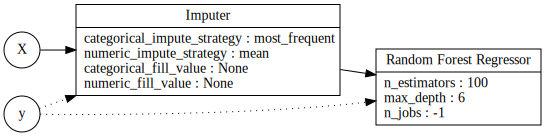

In [27]:
best.graph()

In [28]:
best.save('best_model.cloudpickle')

In [29]:
zipped = list(zip(features, np.round(np.array(best.estimator._component_obj.feature_importances_) * 100, 2)))
sort_zip = sorted(zipped, key = lambda x: x[1], reverse = True)
print(sort_zip)

[('cnt_amount_3', 30.11), ('cnt_amount_6', 15.27), ('cnt_amount_12', 9.76), ('Order_Ago', 7.13), ('cnt_amount_15', 5.17), ('age', 4.99), ('cnt_amount_18', 2.1), ('avg_check', 1.58), ('Mean_Item_Cost', 1.58), ('Lux_Parfume_Amount_12', 1.45), ('sum_amount_3', 1.35), ('Lux_Parfume_Amount_9', 1.27), ('sex', 1.18), ('Mass_amount_3', 1.06), ('cnt_amount_9', 1.03), ('Mass_amount_18', 1.02), ('Parfume_Amount_3', 0.98), ('Parfume_Amount_9', 0.94), ('avg_mass_check', 0.92), ('avg_diff', 0.89), ('Lux_Parfume_AMOUNT_18', 0.87), ('max_diff', 0.82), ('Lux_Parfume_Amount_15', 0.81), ('sum_amount_18', 0.71), ('sum_amount_6', 0.67), ('Mass_amount_6', 0.64), ('Lux_Parfume_Amount_6', 0.63), ('Mass_amount_9', 0.54), ('Lux_Parfume_Amount_3', 0.53), ('Parfume_AMOUNT_18', 0.5), ('Mass_amount_12', 0.5), ('Parfume_Amount_12', 0.49), ('Mass_amount_15', 0.43), ('sum_amount_15', 0.41), ('sum_amount_9', 0.4), ('Parfume_Amount_6', 0.4), ('sum_amount_12', 0.39), ('Parfume_Amount_15', 0.39), ('min_diff', 0.05), ('LIF

In [30]:
scores = best.score(X_test, y_test,  objectives=evalml.objectives.get_core_objectives('regression'))
print(scores)

OrderedDict([('ExpVariance', 0.003972510772297655), ('MaxError', 5.7860639549847495), ('MedianAE', 0.010229233480459392), ('MSE', 0.2051076827762214), ('MAE', 0.0878662447001282), ('R2', 0.003972139375979955), ('Root Mean Squared Error', 0.45288815702800334)])


In [31]:

del X_test
del X_train
del y_test
del y_train
del automl
gc.collect()

210

# AutoML Search Analyz

In [32]:
from sklift.metrics import uplift_at_k

In [2]:
automl2 = evalml.automl.AutoMLSearch.load("automl_big_searching.cloudpickle")

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant


In [3]:
automl2.rankings

,id,pipeline_name,search_order,mean_cv_score,standard_deviation_cv_score,validation_score,percent_better_than_baseline,high_variance_cv,parameters
0,2,Random Forest Regressor w/ Imputer,2,NaN,NaN,0.451723,0.232687,False,{'Imputer': {'categorical_impute_strategy': 'm...
1,13,Random Forest Regressor w/ Imputer + Select Co...,13,NaN,NaN,0.451805,0.214550,False,{'Imputer': {'categorical_impute_strategy': 'm...
2,4,Random Forest Regressor w/ Imputer + RF Regres...,4,NaN,NaN,0.451808,0.213938,False,{'Imputer': {'categorical_impute_strategy': 'm...
3,6,Extra Trees Regressor w/ Imputer + Select Colu...,6,NaN,NaN,0.451836,0.207774,False,{'Imputer': {'categorical_impute_strategy': 'm...
4,8,LightGBM Regressor w/ Imputer + Select Columns...,8,NaN,NaN,0.451843,0.206079,False,{'Imputer': {'categorical_impute_strategy': 'm...
9,7,XGBoost Regressor w/ Imputer + Select Columns ...,7,NaN,NaN,0.452162,0.135638,False,{'Imputer': {'categorical_impute_strategy': 'm...
12,5,Decision Tree Regressor w/ Imputer + Select Co...,5,NaN,NaN,0.452305,0.104040,False,{'Imputer': {'categorical_impute_strategy': 'm...
13,1,Elastic Net Regressor w/ Imputer + Standard Sc...,1,NaN,NaN,0.452371,0.089595,False,{'Imputer': {'categorical_impute_strategy': 'm...
15,3,Elastic Net Regressor w/ Imputer + Standard Sc...,3,NaN,NaN,0.452635,0.031151,False,{'Imputer': {'categorical_impute_strategy': 'm...
16,0,Mean Baseline Regression Pipeline,0,NaN,NaN,0.452776,0.000000,False,{'Baseline Regressor': {'strategy': 'mean'}}


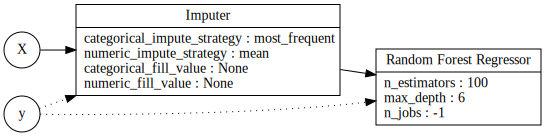

In [4]:
best = automl2.best_pipeline
best.graph()

In [5]:
#Submission
subm = pd.read_csv('ControlSet.csv', sep = ';',dtype={'phone':'str', 'Order_Ago':'float64'})
subm = subm.set_index('phone')
subm.head()

,CommFlag,OrderFlag,Order_Ago,min_diff,max_diff,avg_diff,avg_check,avg_mass_check,Mean_Item_Cost,sum_amount_18,...,Parfume_Amount_12,Parfume_Amount_15,Lux_Parfume_Amount_3,Lux_Parfume_Amount_6,Lux_Parfume_Amount_9,Lux_Parfume_Amount_12,Lux_Parfume_Amount_15,age,LIFECYCLE_TYPE,sex
phone,,,,,,,,,,,,,,,,,,,,,
70001625391,1,0,6.0,141.0,369.0,255.0,7568.7500,7566.2500,2522.916667,15137.5,...,15083.0,15083.0,NaN,NaN,NaN,NaN,NaN,38.0,1,1.0
70009163225,1,0,1.0,1.0,67.0,21.0,3584.1071,3866.2608,16725.833333,100355.0,...,67450.0,69049.0,NaN,NaN,NaN,NaN,NaN,36.0,1,0.0
70032000019,1,0,10.0,NaN,NaN,NaN,2598.5000,2598.5000,1299.250000,2598.5,...,2149.5,2149.5,NaN,NaN,NaN,NaN,NaN,57.0,1,0.0
70185633651,1,0,4.0,7.0,160.0,64.0,1662.4142,994.0666,1662.414286,11636.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
70291167784,1,0,8.0,147.0,219.0,183.0,3190.8333,3161.7500,9572.500000,9572.5,...,2974.5,9572.5,NaN,NaN,NaN,NaN,3249.0,40.0,1,0.0


In [6]:
subm.iloc[:, 3:-3] = subm.iloc[:, 3:-3].fillna(0)
subm.sex = subm.sex.fillna(0)
subm.age = subm.age.fillna(35)
subm.head()

,CommFlag,OrderFlag,Order_Ago,min_diff,max_diff,avg_diff,avg_check,avg_mass_check,Mean_Item_Cost,sum_amount_18,...,Parfume_Amount_12,Parfume_Amount_15,Lux_Parfume_Amount_3,Lux_Parfume_Amount_6,Lux_Parfume_Amount_9,Lux_Parfume_Amount_12,Lux_Parfume_Amount_15,age,LIFECYCLE_TYPE,sex
phone,,,,,,,,,,,,,,,,,,,,,
70001625391,1,0,6.0,141.0,369.0,255.0,7568.7500,7566.2500,2522.916667,15137.5,...,15083.0,15083.0,0.0,0.0,0.0,0.0,0.0,38.0,1,1.0
70009163225,1,0,1.0,1.0,67.0,21.0,3584.1071,3866.2608,16725.833333,100355.0,...,67450.0,69049.0,0.0,0.0,0.0,0.0,0.0,36.0,1,0.0
70032000019,1,0,10.0,0.0,0.0,0.0,2598.5000,2598.5000,1299.250000,2598.5,...,2149.5,2149.5,0.0,0.0,0.0,0.0,0.0,57.0,1,0.0
70185633651,1,0,4.0,7.0,160.0,64.0,1662.4142,994.0666,1662.414286,11636.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,1,0.0
70291167784,1,0,8.0,147.0,219.0,183.0,3190.8333,3161.7500,9572.500000,9572.5,...,2974.5,9572.5,0.0,0.0,0.0,0.0,3249.0,40.0,1,0.0


In [7]:
X_ = subm.iloc[:, 2:].values
X_val = subm.iloc[:, 2:]
Y_val = subm.iloc[:, [0, 1]]

In [8]:
del subm
gc.collect()

0

In [9]:
Y_val.head()

,CommFlag,OrderFlag
phone,,
70001625391,1,0
70009163225,1,0
70032000019,1,0
70185633651,1,0
70291167784,1,0


In [10]:
Y_val_subm = Y_val[(Y_val['CommFlag'] == 1) & (Y_val['OrderFlag'] == 1)]
Y_val[(Y_val['CommFlag'] == 1) & (Y_val['OrderFlag'] == 1)].shape[0]

110465

In [11]:
# X_val['CommFlag'] = 1
# y_pred_1 = best.predict_proba(X_val)
# y_pred_1 = y_pred_1[1]
# y_pred_1.head()

#Class Transform
#X_val['CommFlag'] = 1
y_pred_1 = best.predict(X_)
#y_pred_1 = y_pred_1[1]
y_pred_1.head()

0    0.005802
1    0.128533
2    0.008796
3    0.030684
4    0.019769
dtype: float64

In [12]:
y_pred_1.shape

(3569261,)

<AxesSubplot:ylabel='Count'>

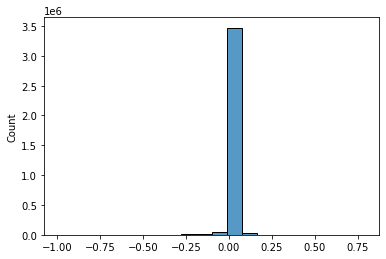

In [13]:
sns.histplot(y_pred_1, bins = 20)

In [14]:
X_val['UpLift'] = y_pred_1.tolist()

In [15]:
X_val.head()

,Order_Ago,min_diff,max_diff,avg_diff,avg_check,avg_mass_check,Mean_Item_Cost,sum_amount_18,cnt_amount_18,Mass_amount_18,...,Parfume_Amount_15,Lux_Parfume_Amount_3,Lux_Parfume_Amount_6,Lux_Parfume_Amount_9,Lux_Parfume_Amount_12,Lux_Parfume_Amount_15,age,LIFECYCLE_TYPE,sex,UpLift
phone,,,,,,,,,,,,,,,,,,,,,
70001625391,6.0,141.0,369.0,255.0,7568.7500,7566.2500,2522.916667,15137.5,2,15132.5,...,15083.0,0.0,0.0,0.0,0.0,0.0,38.0,1,1.0,0.005802
70009163225,1.0,1.0,67.0,21.0,3584.1071,3866.2608,16725.833333,100355.0,28,88924.0,...,69049.0,0.0,0.0,0.0,0.0,0.0,36.0,1,0.0,0.128533
70032000019,10.0,0.0,0.0,0.0,2598.5000,2598.5000,1299.250000,2598.5,1,2598.5,...,2149.5,0.0,0.0,0.0,0.0,0.0,57.0,1,0.0,0.008796
70185633651,4.0,7.0,160.0,64.0,1662.4142,994.0666,1662.414286,11636.9,7,7263.4,...,0.0,0.0,0.0,0.0,0.0,0.0,35.0,1,0.0,0.030684
70291167784,8.0,147.0,219.0,183.0,3190.8333,3161.7500,9572.500000,9572.5,3,6323.5,...,9572.5,0.0,0.0,0.0,0.0,3249.0,40.0,1,0.0,0.019769


In [16]:
print(X_.shape)
print(X_val.shape)

(3569261, 40)
(3569261, 41)


In [17]:
X_val_metric = X_val.merge(Y_val, on = 'phone')
print(X_val_metric.shape)
X_val_metric.head()


(3569261, 43)


,Order_Ago,min_diff,max_diff,avg_diff,avg_check,avg_mass_check,Mean_Item_Cost,sum_amount_18,cnt_amount_18,Mass_amount_18,...,Lux_Parfume_Amount_6,Lux_Parfume_Amount_9,Lux_Parfume_Amount_12,Lux_Parfume_Amount_15,age,LIFECYCLE_TYPE,sex,UpLift,CommFlag,OrderFlag
phone,,,,,,,,,,,,,,,,,,,,,
70001625391,6.0,141.0,369.0,255.0,7568.7500,7566.2500,2522.916667,15137.5,2,15132.5,...,0.0,0.0,0.0,0.0,38.0,1,1.0,0.005802,1,0
70009163225,1.0,1.0,67.0,21.0,3584.1071,3866.2608,16725.833333,100355.0,28,88924.0,...,0.0,0.0,0.0,0.0,36.0,1,0.0,0.128533,1,0
70032000019,10.0,0.0,0.0,0.0,2598.5000,2598.5000,1299.250000,2598.5,1,2598.5,...,0.0,0.0,0.0,0.0,57.0,1,0.0,0.008796,1,0
70185633651,4.0,7.0,160.0,64.0,1662.4142,994.0666,1662.414286,11636.9,7,7263.4,...,0.0,0.0,0.0,0.0,35.0,1,0.0,0.030684,1,0
70291167784,8.0,147.0,219.0,183.0,3190.8333,3161.7500,9572.500000,9572.5,3,6323.5,...,0.0,0.0,0.0,3249.0,40.0,1,0.0,0.019769,1,0


In [18]:
any(X_val_metric.OrderFlag.isna())

False

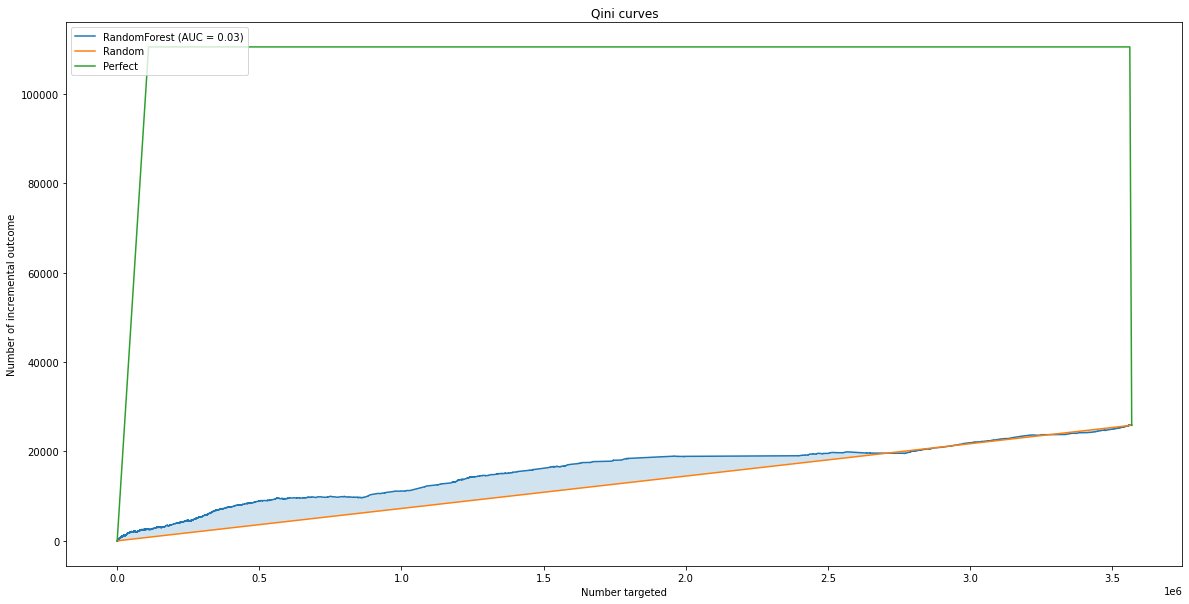

In [19]:
from sklift.viz import plot_qini_curve, plot_uplift_curve
import matplotlib.pyplot as plt
 
%matplotlib inline 
 
fig, ax = plt.subplots(figsize = (20, 10))
ax.set_title('Qini curves')

plot_qini_curve(X_val_metric.OrderFlag.values, X_val_metric.UpLift.values, X_val_metric.CommFlag.values,
    perfect=True, name='RandomForest', ax=ax
);
ax.legend(loc = 2)
#plt.savefig('qini.png')



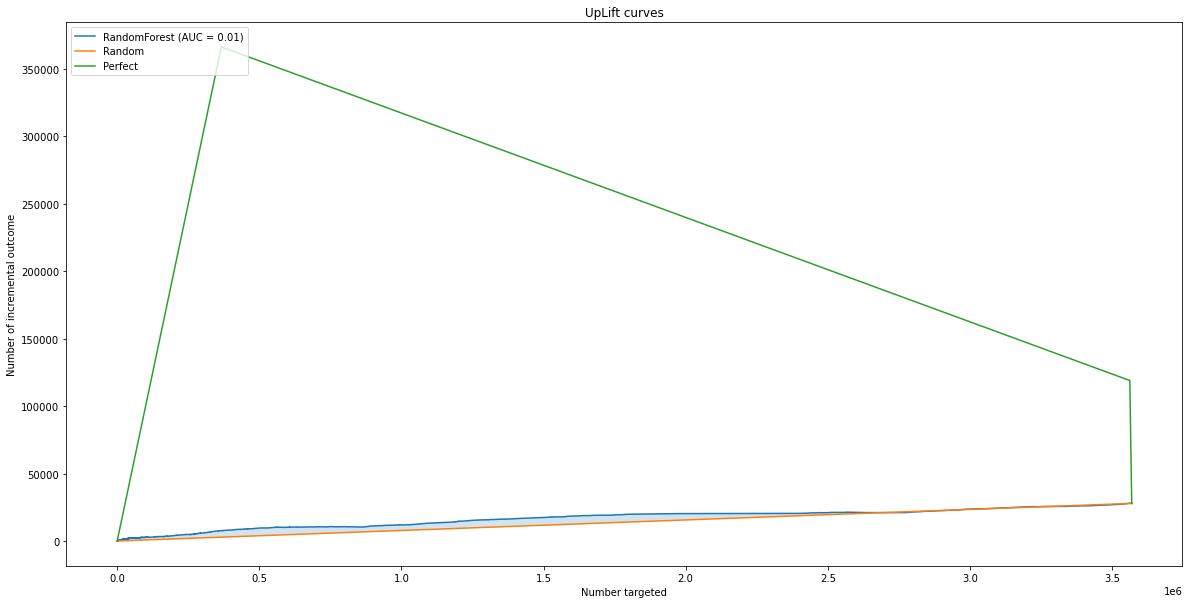

In [20]:
%matplotlib inline 
 
fig, ax = plt.subplots(figsize = (20, 10))
ax.set_title('UpLift curves')

plot_uplift_curve(X_val_metric.OrderFlag.values, X_val_metric.UpLift.values, X_val_metric.CommFlag.values,
    perfect=True, name='RandomForest', ax=ax
);
ax.legend(loc = 2)
#plt.savefig('UpLift.png')

C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



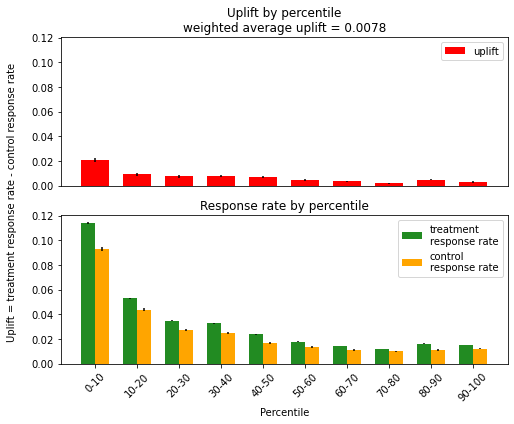

In [36]:


from sklift.viz import plot_uplift_by_percentile


plot_uplift = plot_uplift_by_percentile(X_val_metric.OrderFlag.values, X_val_metric.UpLift.values, X_val_metric.CommFlag.values, kind='bar')



In [28]:
uplift_at_k

0.011035632679228441

In [57]:
h = 0.01
T = int(1 / h)
s = 0.01
cr = []
ac = []
part = []
for i in range(0, T):
    X_val_subm_i = X_val.sort_values('UpLift', ascending= False).iloc[0: round(X_val.shape[0] * s), :].merge(Y_val[Y_val['CommFlag'] == 1], on = 'phone', suffixes=('', '_y'))
    X_val_subm_i = X_val_subm_i.merge(Y_val_subm, how='left', on = 'phone', suffixes=('', '_y'))
    cr.append(X_val_subm_i[X_val_subm_i.OrderFlag == 1].shape[0] / X_val_subm_i.shape[0])
    ac.append(X_val_subm_i[X_val_subm_i.OrderFlag == 1].shape[0] / Y_val_subm.shape[0])
    part.append(s)
    del X_val_subm_i
    gc.collect()
    s += h

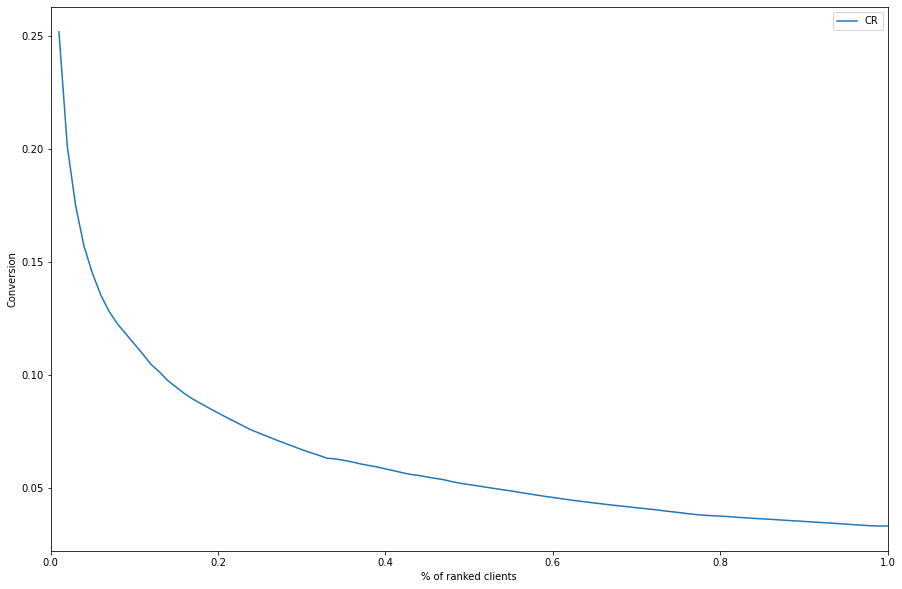

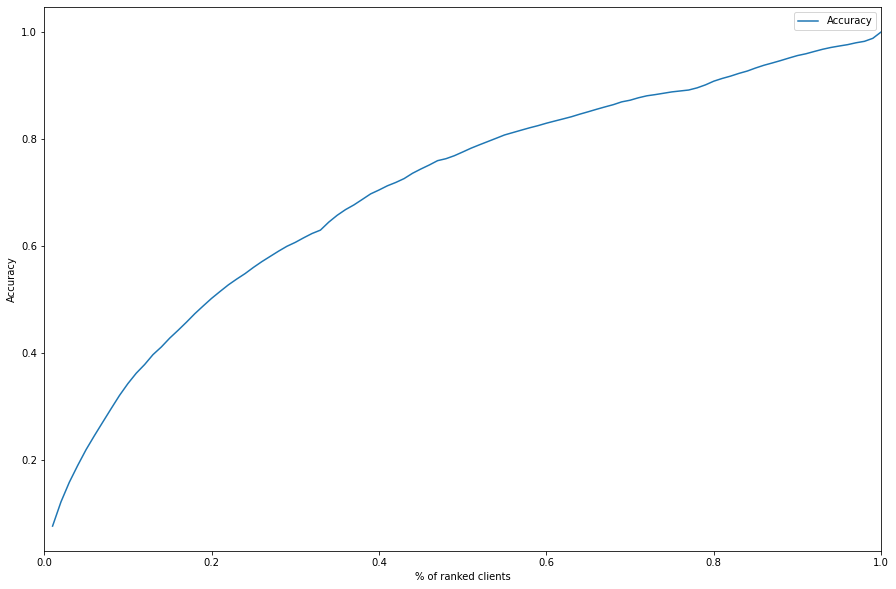

In [58]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (15, 10))
plt.plot(part, cr, label = 'CR')
plt.legend()
plt.xlabel('% of ranked clients')
plt.ylabel('Conversion')

plt.xlim(0, 1)
plt.show()

%matplotlib inline
fig, ax = plt.subplots(figsize = (15, 10))
plt.plot(part, ac, label = 'Accuracy')

plt.xlim(0, 1)
plt.xlabel('% of ranked clients')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [72]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.DataFrame({'Part':part, 'CR':cr, 'ACC':ac})


,Part,CR,ACC
0,0.01,0.252012,0.075952
1,0.02,0.201355,0.121079
2,0.03,0.174942,0.157878
3,0.04,0.157119,0.189264
4,0.05,0.145209,0.218829
5,0.06,0.135547,0.245109
6,0.07,0.128285,0.270439
7,0.08,0.122787,0.295623
8,0.09,0.118378,0.320364
9,0.10,0.113954,0.342398


<p style = "font-color:blue;">
Part	CR	ACC <br>
0.10	0.115568	0.317885<br>
0.15	0.098023	0.404434<br>
0.20	0.087061	0.478943<br>
0.25	0.079196	0.544595<br>
0.30	0.072784	0.600603<br>
0.35	0.067779	0.652520<br>
0.40	0.063647	0.700270<br>
0.45	0.060014	0.742842<br>
0.50	0.056950	0.783243<br>
0.55	0.054026	0.817332<br>
0.60	0.051604	0.851656<br>
0.65	0.049165	0.879014<br>
0.70	0.047004	0.905033<br>
0.75	0.044985	0.928019<br>
0.80	0.043039	0.947082<br>
0.85	0.041261	0.964702<br>
0.90	0.039611	0.980591<br>
0.95	0.037957	0.991854<br>
1.00	0.036355	1.000000<br>
1.05	0.036355	1.000000<br>
</p>

In [73]:
Y_val[Y_val['CommFlag'] == 1].shape[0]

3306567

In [58]:
 X_val.sort_values('UpLift', ascending= False).iloc[0: round(X_val.shape[0] * s), :].merge(Y_val[Y_val['CommFlag'] == 1], on = 'phone', suffixes=('', '_y')).shape

(506975, 43)

In [30]:
X_val_subm.head()

,Order_Ago,min_diff,max_diff,avg_diff,avg_check,avg_mass_check,Mean_Item_Cost,sum_amount_18,cnt_amount_18,Mass_amount_18,...,Lux_Parfume_Amount_9,Lux_Parfume_Amount_12,Lux_Parfume_Amount_15,age,LIFECYCLE_TYPE,sex,CommFlag_x,OrderFlag_x,CommFlag_y,OrderFlag_y
phone,,,,,,,,,,,,,,,,,,,,,
79000000911,2.0,0.0,0.0,0.0,5471.0000,5471.00,5471.000000,5471.00,1,5471.00,...,0.0,0.0,0.0,NaN,0,1.0,NaN,NaN,NaN,NaN
79000001507,3.0,0.0,0.0,0.0,893.0000,893.00,893.000000,893.00,1,893.00,...,0.0,0.0,0.0,41.0,1,0.0,NaN,NaN,NaN,NaN
79000002803,12.0,43.0,43.0,43.0,4073.0833,4069.75,6109.625000,12219.25,3,12209.25,...,0.0,0.0,0.0,30.0,1,1.0,NaN,NaN,NaN,NaN
79000002888,4.0,0.0,0.0,0.0,5233.0000,5233.00,2616.500000,5233.00,1,5233.00,...,0.0,0.0,0.0,NaN,1,0.0,NaN,NaN,NaN,NaN
79000003036,6.0,137.0,137.0,137.0,2909.0000,2905.50,646.444444,5818.00,2,5811.00,...,0.0,0.0,0.0,39.0,1,1.0,NaN,NaN,NaN,NaN


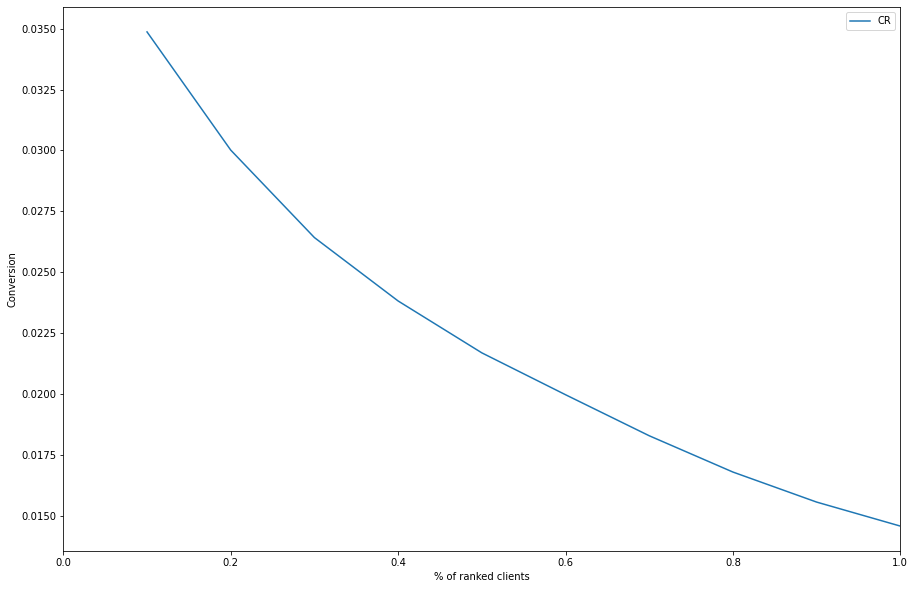

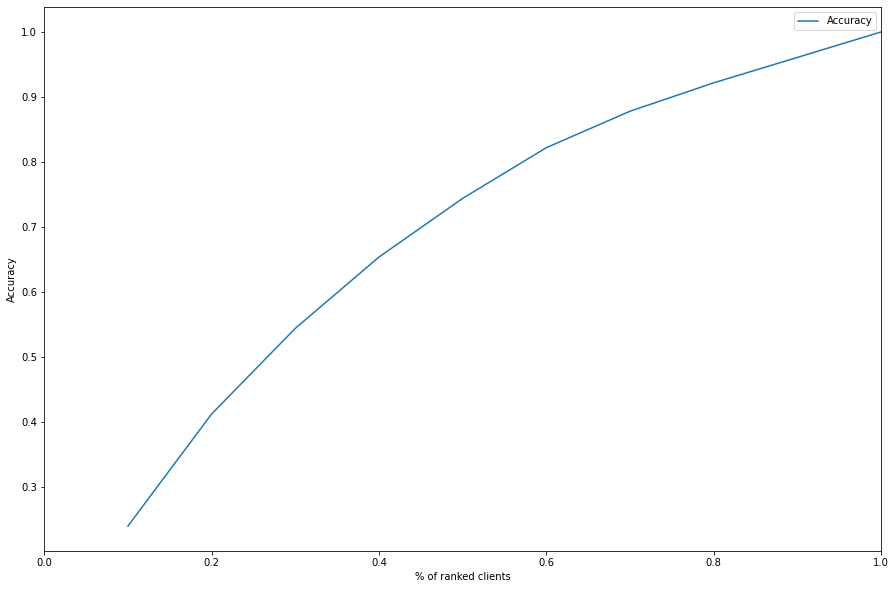

In [51]:
h = 0.1
s = 0.1
cr = []
ac = []
part = []
for i in range(0, 10):
    X_val_subm_i = X_val.sort_values('UpLift', ascending= False).iloc[0: round(X_val.shape[0] * s), :]
    X_val_subm_i = X_val_subm_i.merge(Y_val_subm, how='left', on = 'phone', suffixes=('', '_y'))
    cr.append(X_val_subm_i[X_val_subm_i.OrderFlag == 1].shape[0] / X_val_subm_i.shape[0])
    ac.append(X_val_subm_i[X_val_subm_i.OrderFlag == 1].shape[0] / Y_val_subm.shape[0])
    part.append(s)
    del X_val_subm_i
    gc.collect()
    s += h
    
    
%matplotlib inline
fig, ax = plt.subplots(figsize = (15, 10))
plt.plot(part, cr, label = 'CR')
plt.legend()
plt.xlabel('% of ranked clients')
plt.ylabel('Conversion')

plt.xlim(0, 1)
plt.show()

%matplotlib inline
fig, ax = plt.subplots(figsize = (15, 10))
plt.plot(part, ac, label = 'Accuracy')

plt.xlim(0, 1)
plt.xlabel('% of ranked clients')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [53]:
pd.DataFrame({'CR':cr, 'Part':part})

,CR,Part
0,0.136361,0.1
1,0.097872,0.2
2,0.078931,0.3
3,0.068516,0.4
4,0.060734,0.5
5,0.054218,0.6
6,0.048734,0.7
7,0.043914,0.8
8,0.039896,0.9
9,0.036616,1.0


In [79]:
del subm
del X_val
del Y_val
del X_val_subm
del Y_val_subm

NameError: name 'subm' is not defined

In [80]:
gc.collect()

8337

# Load Submission

In [2]:
with pyodbc.connect('DRIVER={SQL SERVER};SERVER=SAS-CI-DB1-P;') as conn:
    strq = 'SELECT DISTINCT phone\
                    , CommFlag\
                    , OrderFlag\
                    , Order_Ago\
                    , min_diff\
                    , max_diff\
                    , avg_diff\
                    , avg_check\
                    , avg_mass_check\
                    , Mean_Item_Cost\
                    , sum_amount_18\
                    , cnt_amount_18\
                    , Mass_amount_18\
                    , Parfume_AMOUNT_18\
                    , Lux_Parfume_AMOUNT_18\
                    , sum_amount_3\
                    , sum_amount_6\
                    , sum_amount_9\
                    , sum_amount_12\
                    , sum_amount_15\
                    , cnt_amount_3\
                    , cnt_amount_6\
                    , cnt_amount_9\
                    , cnt_amount_12\
                    , cnt_amount_15\
                    , Mass_amount_3\
                    , Mass_amount_6\
                    , Mass_amount_9\
                    , Mass_amount_12\
                    , Mass_amount_15\
                    , Parfume_Amount_3\
                    , Parfume_Amount_6\
                    , Parfume_Amount_9\
                    , Parfume_Amount_12\
                    , Parfume_Amount_15\
                    , Lux_Parfume_Amount_3\
                    , Lux_Parfume_Amount_6\
                    , Lux_Parfume_Amount_9\
                    , Lux_Parfume_Amount_12\
                    , Lux_Parfume_Amount_15\
                    , age\
                    , LIFECYCLE_TYPE\
                    , sex \
                    FROM ##DataSet\
                    WHERE cnt_amount_18 > 0'
    df = pd.read_sql(strq, conn)

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


In [3]:
df.head()

,phone,CommFlag,OrderFlag,Order_Ago,min_diff,max_diff,avg_diff,avg_check,avg_mass_check,Mean_Item_Cost,...,Parfume_Amount_12,Parfume_Amount_15,Lux_Parfume_Amount_3,Lux_Parfume_Amount_6,Lux_Parfume_Amount_9,Lux_Parfume_Amount_12,Lux_Parfume_Amount_15,age,LIFECYCLE_TYPE,sex
0,70000136255,1,0,5,3.0,9.0,6.0,2637.8888,2245.0000,1582.733333,...,10307.0,10307.0,NaN,NaN,NaN,NaN,NaN,24.0,0,0.0
1,70021067460,1,0,15,240.0,240.0,240.0,229.0000,229.0000,229.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0,1,0.0
2,70152618547,1,0,2,3.0,214.0,61.0,2363.4891,1874.4562,2578.351818,...,599.0,599.0,NaN,NaN,NaN,NaN,NaN,66.0,1,0.0
3,70501308857,1,0,3,2.0,174.0,46.0,1139.6608,909.3663,683.796500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,1,0.0
4,70501322121,1,0,6,11.0,135.0,53.0,2018.9642,1916.9000,441.648438,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,1,0.0


In [4]:
df[df.Order_Ago.isna()]

,phone,CommFlag,OrderFlag,Order_Ago,min_diff,max_diff,avg_diff,avg_check,avg_mass_check,Mean_Item_Cost,...,Parfume_Amount_12,Parfume_Amount_15,Lux_Parfume_Amount_3,Lux_Parfume_Amount_6,Lux_Parfume_Amount_9,Lux_Parfume_Amount_12,Lux_Parfume_Amount_15,age,LIFECYCLE_TYPE,sex


In [5]:
df.to_csv('ControlSet.csv', index = False, sep = ';')

In [6]:
del df

In [8]:
gc.collect()

463